In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

from sklearn.cluster import KMeans

# Goal

The goal of this notebook is to detect and replace the values of any loss of data

## Sensor dataset

We have two types of outliers in out dataset, missing data aka NaN or data putted as 0.
For both temperatures, it's pretty straightforwards because the temps never goes below 20 degrees (roughly), so detecting missing values is easy.

But for irradiation, we have to detect where values at 0 shouldn't be there.

UPDDATE 1: Noticed that I was wrong, no real value at 0 but lots of missing values, not NaN but missing, so need to remake the dataset to add those dates and times at those points.

To do that, we'll "split" the dataset use Kmeans clustering, and detect all values at 0 in the middle of the day.

Afterwards, we'll be using the "cleaned" set to apply feature engineering for each columns, and finally chose, train and use a model to replace each missing/wrong values

Finally, we'll save the new dataset as parquet file.


In [4]:
from src.data_prep import *
dfs = load_sensor("dataset/Plant_1_Weather_Sensor_Data.csv", save=False)
dfs[0]

NameError: name 'load_sensor' is not defined

In [31]:
# Preping the datasets for cleaning

# Loading datasets
ps1 = pd.read_csv("dataset/Plant_1_Weather_Sensor_Data.csv")
ps2 = pd.read_csv("dataset/Plant_2_Weather_Sensor_Data.csv")

sdate=datetime.date(2020, 5, 15)
edate = datetime.date(2020, 6, 17)
timeset = pd.DataFrame({'DATE_TIME' : pd.date_range(start=sdate, end=edate, freq='15min')})
timeset['date'] = timeset['DATE_TIME'].dt.date
timeset['time'] = timeset['DATE_TIME'].dt.time
timetemp = pd.DataFrame({'time': p['time'].unique()})
timetemp['time_id'] = [x for x in range(timetemp.shape[0])]
timeset= timeset.merge(timetemp, on='time')


ps= [ps1,ps2]
new_ps_wNaN = []
new_ps_woNaN = []
for p in ps:
    # Drop unused columns
    p = p.drop(columns=['SOURCE_KEY','PLANT_ID'])
    # Transform datetime to 2 separate columns
    p['DATE_TIME'] = pd.to_datetime(p['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
    pNaN = p.merge(timeset, left_index=True, right_index=True, how='left')
    pp = pd.DataFrame({'time': p['time'].unique()})
    pp['time_id'] = [x for x in range(pp.shape[0])]
    p.merge(pp, on='time')
    # Adding new columns 
    p['IrrMulATemp'] = p['AMBIENT_TEMPERATURE'] * p['IRRADIATION']
    pNaN['IrrMulATemp'] = pNaN['AMBIENT_TEMPERATURE'] * pNaN['IRRADIATION']
    # Apply a naive clustering processing only for training (without NaN values)
    km = KMeans(n_clusters=3, max_iter=350, n_init=50)
    p['cluster'] = km.fit(p[['time_id','IRRADIATION']]).labels_
    # Appends to respectives lists
    new_ps_wNaN.append(pNaN)
    new_ps_woNaN.append(p)
new_ps_woNaN[0]

KeyError: 'time'

In [21]:
print(new_ps[0]['date'].count())
print(new_ps[0].tail(1)['date'].values)

start_date = datetime.date(2020, 5, 15)
end_date = datetime.date(2020, 6, 17)

p = pd.DataFrame({'DATE_TIME' : pd.date_range(start=start_date, end=end_date, freq='15min')})
print(len(p))
p['date'] = p['DATE_TIME'].dt.date
p['time'] = p['DATE_TIME'].dt.time
pp = pd.DataFrame({'time': p['time'].unique()})
pp['time_id'] = [x for x in range(pp.shape[0])]
p= p.merge(pp, on='time')
new_ps[0].merge(p, left_index=True, right_index=True, how='left')

3182
[datetime.date(2020, 6, 17)]


,DATE_TIME_x,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,date_x,time_x,time_id_x,IrrMulATemp,cluster,DATE_TIME_y,date_y,time_y,time_id_y
0,2020-05-15 00:00:00,25.184316,22.857507,0.0,2020-05-15,00:00:00,0,0.0,1,2020-05-15,2020-05-15,00:00:00,0.0
1,2020-05-17 00:00:00,24.170166,21.631490,0.0,2020-05-17,00:00:00,0,0.0,1,2020-05-16,2020-05-16,00:00:00,0.0
2,2020-05-18 00:00:00,21.155691,20.599400,0.0,2020-05-18,00:00:00,0,0.0,1,2020-05-17,2020-05-17,00:00:00,0.0
3,2020-05-19 00:00:00,22.610982,20.609906,0.0,2020-05-19,00:00:00,0,0.0,1,2020-05-18,2020-05-18,00:00:00,0.0
4,2020-05-20 00:00:00,22.465285,20.111123,0.0,2020-05-20,00:00:00,0,0.0,1,2020-05-19,2020-05-19,00:00:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3177,2020-06-13 23:45:00,22.205029,20.459212,0.0,2020-06-13,23:45:00,95,0.0,2,NaT,NaN,NaN,NaN
3178,2020-06-14 23:45:00,23.418154,22.447845,0.0,2020-06-14,23:45:00,95,0.0,2,NaT,NaN,NaN,NaN
3179,2020-06-15 23:45:00,23.641211,23.051286,0.0,2020-06-15,23:45:00,95,0.0,2,NaT,NaN,NaN,NaN
3180,2020-06-16 23:45:00,22.892004,21.216600,0.0,2020-06-16,23:45:00,95,0.0,2,NaT,NaN,NaN,NaN


<Axes: xlabel='time_id', ylabel='IRRADIATION'>

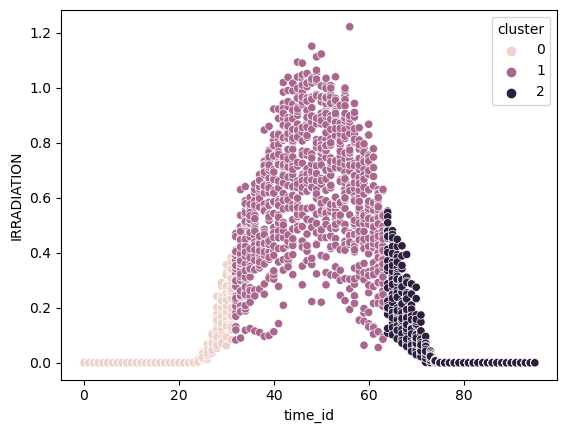

In [139]:
sns.scatterplot(data=new_ps[0], x='time_id', y='IRRADIATION', hue='cluster')

In [112]:
new_ps[0][new_ps[0]['IRRADIATION'] <= 0].groupby('time_id').count().reset_index()

,time_id,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,date,time,IrrMulATemp,cluster
0,0,33,33,33,33,33,33,33,33
1,1,33,33,33,33,33,33,33,33
2,2,33,33,33,33,33,33,33,33
3,3,32,32,32,32,32,32,32,32
4,4,32,32,32,32,32,32,32,32
5,5,32,32,32,32,32,32,32,32
6,6,32,32,32,32,32,32,32,32
7,7,32,32,32,32,32,32,32,32
8,8,32,32,32,32,32,32,32,32
9,9,32,32,32,32,32,32,32,32


In [107]:
new_ps[0].isna().values.sum()
temp =new_ps[0][new_ps[0]['IRRADIATION'] == 0].groupby('time_id').count().reset_index()

c:\Users\Shadow\anaconda3\envs\tgpu\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


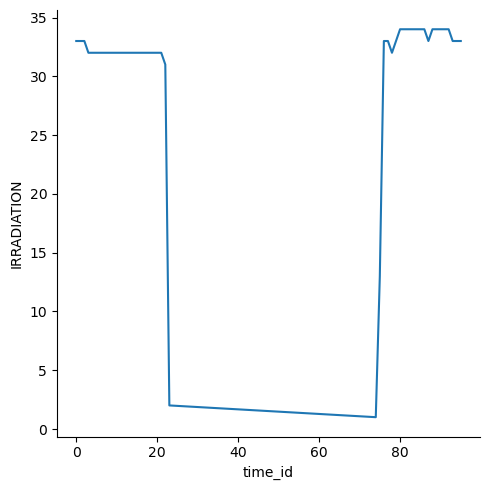

In [109]:
sns.relplot(data=temp, kind='line', x='time_id', y='IRRADIATION')

In [127]:
t= new_ps[0][(new_ps[0]['IRRADIATION'] == 0) & ((new_ps[0]['time_id'] > 25) &  (new_ps[0]['time_id'] < 80))]
t

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,date,time,time_id,IrrMulATemp,cluster
2442,2020-05-19 18:30:00,22.543171,20.736243,0.0,2020-05-19,18:30:00,74,0.0,2
2472,2020-05-15 18:45:00,27.884064,25.961947,0.0,2020-05-15,18:45:00,75,0.0,2
2473,2020-05-16 18:45:00,28.685984,25.503219,0.0,2020-05-16,18:45:00,75,0.0,2
2474,2020-05-17 18:45:00,25.996614,24.617096,0.0,2020-05-17,18:45:00,75,0.0,2
2475,2020-05-18 18:45:00,24.629045,23.324506,0.0,2020-05-18,18:45:00,75,0.0,2
...,...,...,...,...,...,...,...,...,...
2637,2020-06-13 19:45:00,23.870742,22.224394,0.0,2020-06-13,19:45:00,79,0.0,2
2638,2020-06-14 19:45:00,24.249109,22.757745,0.0,2020-06-14,19:45:00,79,0.0,2
2639,2020-06-15 19:45:00,23.201117,22.128701,0.0,2020-06-15,19:45:00,79,0.0,2
2640,2020-06-16 19:45:00,24.105043,22.125271,0.0,2020-06-16,19:45:00,79,0.0,2


In [156]:
import datetime
t = new_ps[0][new_ps[0]['date'] == datetime.date(2020, 5, 21)]
t[t['time_id'] ==20]
# sns.relplot(data=new_ps[0][new_ps[0]['date'] == datetime.date(2020, 5, 21)], x='time_id', y='IRRADIATION', hue='SOURCE_KEY', kind='line')~

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,date,time,time_id,IrrMulATemp,cluster


In [137]:
# new_ps[0][(new_ps[0]['cluster'] == 0) & (new_ps[0].isna())]
new_ps[0].isna().count()

DATE_TIME              3182
AMBIENT_TEMPERATURE    3182
MODULE_TEMPERATURE     3182
IRRADIATION            3182
date                   3182
time                   3182
time_id                3182
IrrMulATemp            3182
cluster                3182
dtype: int64

c:\Users\Shadow\anaconda3\envs\tgpu\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


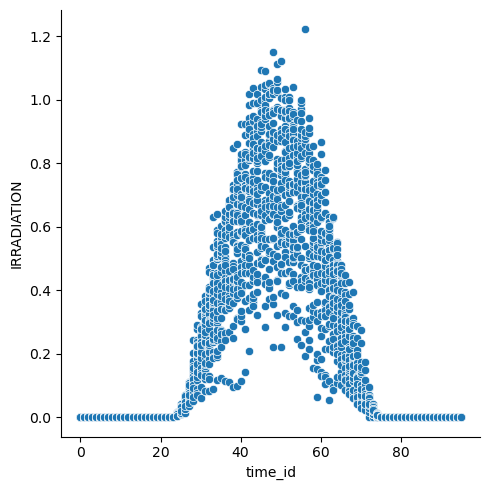

In [132]:
sns.relplot(data=new_ps[0], x='time_id', y='IRRADIATION')

array([[<Axes: xlabel='time'>, <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>]], dtype=object)

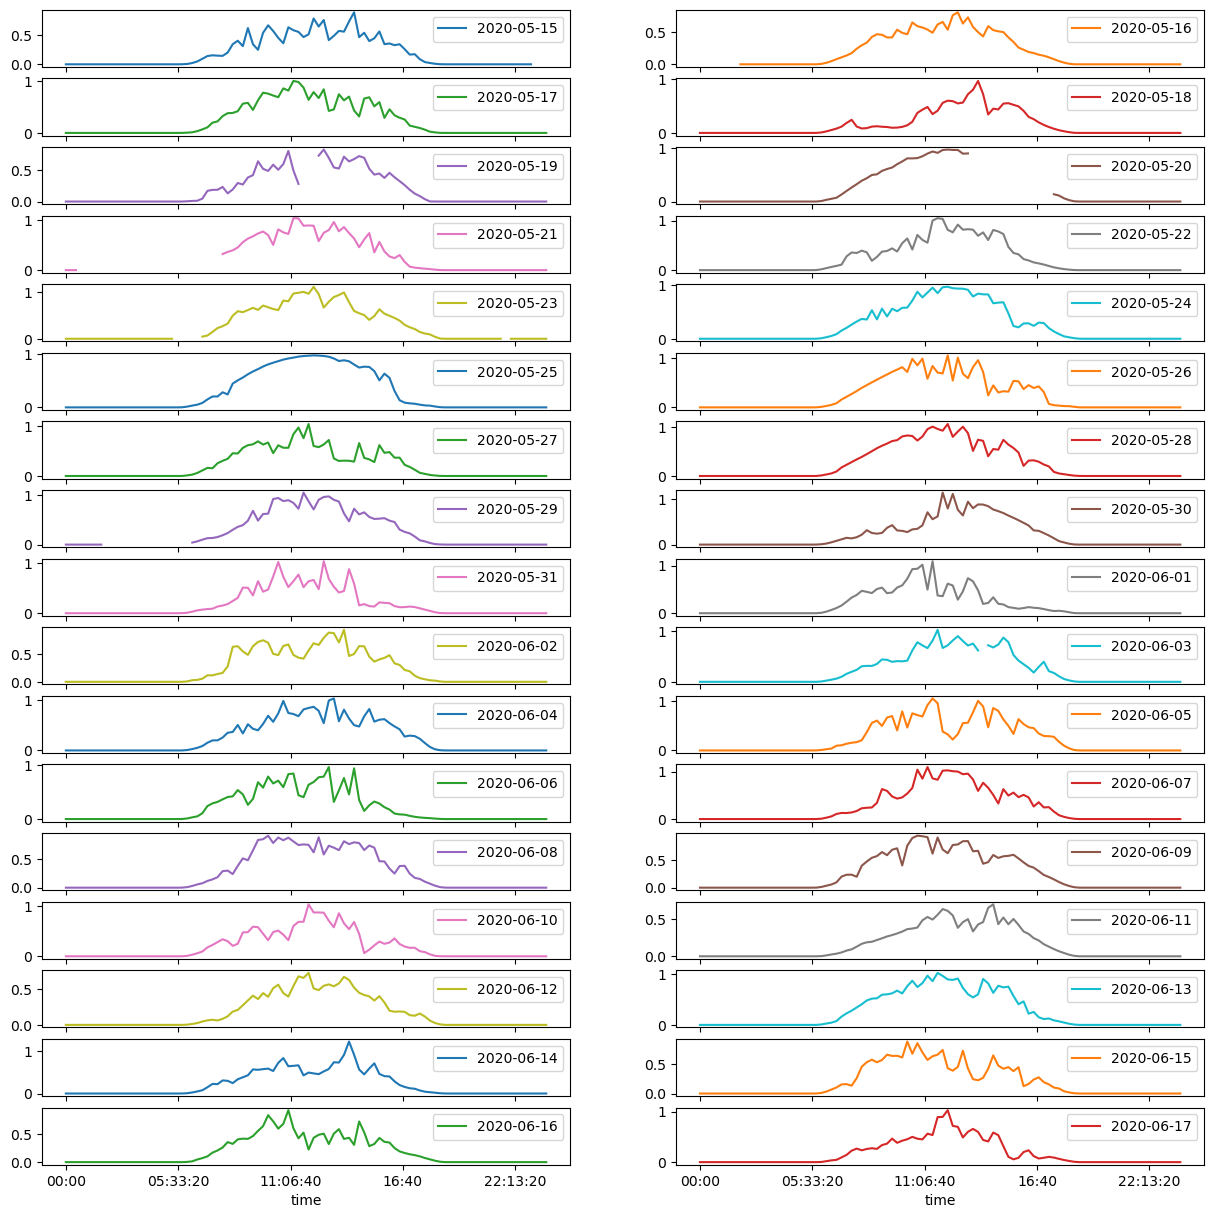

In [134]:
new_ps[0].pivot_table(index='time', columns='date', values='IRRADIATION').plot(subplots=True, layout=(17,2), figsize=(15,15))